---
## 1. Setup and Data Loading

In [1]:
# ============================================
# IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    print("⚠️ XGBoost not installed. Will skip XGBoost model.")
    HAS_XGBOOST = False

# SMOTE for class imbalance
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    print("⚠️ imbalanced-learn not installed. Will skip SMOTE.")
    HAS_SMOTE = False

# Model persistence
import joblib
import os

print("✅ Libraries imported")
print(f"   XGBoost available: {HAS_XGBOOST}")
print(f"   SMOTE available: {HAS_SMOTE}")

✅ Libraries imported
   XGBoost available: True
   SMOTE available: True


In [2]:
# ============================================
# LOAD TRAINING AND VALIDATION DATA
# ============================================

df_train = pd.read_csv('../data/processed/train.csv')
df_val = pd.read_csv('../data/processed/val.csv')

print(f"✅ Loaded training data: {df_train.shape[0]:,} rows")
print(f"   Years: {df_train['Year'].unique()}")

print(f"\n✅ Loaded validation data: {df_val.shape[0]:,} rows")
print(f"   Years: {df_val['Year'].unique()}")

✅ Loaded training data: 5,166 rows
   Years: [2017 2018 2019]

✅ Loaded validation data: 3,444 rows
   Years: [2020 2021]


---
## 2. Define Feature Columns

In [3]:
# ============================================
# DEFINE FEATURE COLUMNS
# ============================================

# Columns to EXCLUDE from features
exclude_cols = [
    # Identifiers
    'UNITID', 'Institution_Name', 'Year', 'State',
    # Target
    'Target_Trajectory', 'Target_Label'
]

# Numeric feature columns
numeric_features = [
    'Grand Total Revenue', 'Grand Total Expenses', 'Total_Athletes',
    'Efficiency_Ratio', 'Revenue_Per_Athlete', 'Reports_Exactly_One',
    'Revenue_Growth_1yr', 'Expense_Growth_1yr',
    'Revenue_CAGR_2yr', 'Expense_CAGR_2yr', 'Efficiency_Mean_2yr',
    'Revenue_Volatility_2yr', 'Expense_Volatility_2yr'
]

# Categorical features (will be encoded)
categorical_features = ['Division']

print("📋 FEATURE CONFIGURATION:")
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Total features: {len(numeric_features) + len(categorical_features)}")

📋 FEATURE CONFIGURATION:
   Numeric features: 13
   Categorical features: 1
   Total features: 14


---
## 3. Prepare Features and Target

In [4]:
# ============================================
# ENCODE CATEGORICAL FEATURES
# ============================================

# Create copies to avoid modifying original data
train_data = df_train.copy()
val_data = df_val.copy()

# Encode Division (D1, D2, D3, Other)
division_map = {'D1': 3, 'D2': 2, 'D3': 1, 'Other': 0, 'Unknown': 0}
train_data['Division_Encoded'] = train_data['Division'].map(division_map).fillna(0)
val_data['Division_Encoded'] = val_data['Division'].map(division_map).fillna(0)

print("✅ Encoded Division feature")
print(train_data.groupby('Division')['Division_Encoded'].first())

✅ Encoded Division feature
Division
D1         3
Other      0
Unknown    0
Name: Division_Encoded, dtype: int64


In [5]:
# ============================================
# CREATE FEATURE MATRIX AND TARGET
# ============================================

# Final feature list
feature_columns = numeric_features + ['Division_Encoded']

# Extract features and target
X_train = train_data[feature_columns].copy()
y_train = train_data['Target_Label'].copy()

X_val = val_data[feature_columns].copy()
y_val = val_data['Target_Label'].copy()

print(f"✅ Feature matrices created:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

✅ Feature matrices created:
   X_train: (5166, 14)
   y_train: (5166,)
   X_val: (3444, 14)
   y_val: (3444,)


In [6]:
# ============================================
# HANDLE MISSING VALUES
# ============================================

print("📊 Missing values BEFORE handling:")
print(f"   X_train: {X_train.isna().sum().sum():,} total missing")
print(f"   X_val: {X_val.isna().sum().sum():,} total missing")

# Fill missing values with median (from training data only)
train_medians = X_train.median()

X_train = X_train.fillna(train_medians)
X_val = X_val.fillna(train_medians)  # Use TRAINING medians for val

print("\n📊 Missing values AFTER handling:")
print(f"   X_train: {X_train.isna().sum().sum():,} total missing")
print(f"   X_val: {X_val.isna().sum().sum():,} total missing")

📊 Missing values BEFORE handling:
   X_train: 0 total missing
   X_val: 0 total missing

📊 Missing values AFTER handling:
   X_train: 0 total missing
   X_val: 0 total missing


In [7]:
# ============================================
# HANDLE INFINITE VALUES
# ============================================

# Replace infinities with large values
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)

# Fill with median again
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_val = X_val.fillna(train_medians)

print("✅ Handled infinite values")

✅ Handled infinite values


---
## 4. Scale Features

In [8]:
# ============================================
# SCALE FEATURES
# ============================================

# Fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use TRAINING scaler

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns)

print("✅ Features scaled using StandardScaler")
print("   Scaler fitted on training data only")

✅ Features scaled using StandardScaler
   Scaler fitted on training data only


---
## 5. Handle Class Imbalance with SMOTE

In [9]:
# ============================================
# CLASS DISTRIBUTION BEFORE SMOTE
# ============================================

print("📊 CLASS DISTRIBUTION (Training set):")
class_counts = y_train.value_counts().sort_index()
class_names = {0: 'Declining', 1: 'Stable', 2: 'Improving'}

for label, count in class_counts.items():
    pct = count / len(y_train) * 100
    print(f"   {class_names[label]} ({label}): {count:,} ({pct:.1f}%)")

📊 CLASS DISTRIBUTION (Training set):
   Declining (0.0): 2,787 (53.9%)
   Stable (1.0): 1,844 (35.7%)
   Improving (2.0): 535 (10.4%)


In [10]:
# ============================================
# APPLY SMOTE
# ============================================

if HAS_SMOTE:
    print("\n🔄 Applying SMOTE to balance classes...")
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print("\n📊 CLASS DISTRIBUTION AFTER SMOTE:")
    resampled_counts = pd.Series(y_train_resampled).value_counts().sort_index()
    
    for label, count in resampled_counts.items():
        pct = count / len(y_train_resampled) * 100
        print(f"   {class_names[label]} ({label}): {count:,} ({pct:.1f}%)")
    
    print(f"\n✅ Training set size: {len(y_train):,} → {len(y_train_resampled):,}")
else:
    print("\n⚠️ SMOTE not available. Using original class distribution.")
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train


🔄 Applying SMOTE to balance classes...

📊 CLASS DISTRIBUTION AFTER SMOTE:
   Declining (0.0): 2,787 (33.3%)
   Stable (1.0): 2,787 (33.3%)
   Improving (2.0): 2,787 (33.3%)

✅ Training set size: 5,166 → 8,361


---
## 6. Train Models

In [11]:
# ============================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================

print("🔧 Training Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Additional class weighting
    multi_class='multinomial',
    solver='lbfgs'
)

lr_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on validation set
lr_val_pred = lr_model.predict(X_val_scaled)
lr_val_acc = accuracy_score(y_val, lr_val_pred)
lr_val_f1 = f1_score(y_val, lr_val_pred, average='weighted')

print(f"\n✅ Logistic Regression trained")
print(f"   Validation Accuracy: {lr_val_acc:.4f}")
print(f"   Validation F1 (weighted): {lr_val_f1:.4f}")

🔧 Training Logistic Regression...

✅ Logistic Regression trained
   Validation Accuracy: 0.5557
   Validation F1 (weighted): 0.5690


In [12]:
# ============================================
# MODEL 2: RANDOM FOREST
# ============================================

print("🔧 Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on validation set
rf_val_pred = rf_model.predict(X_val_scaled)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred, average='weighted')

print(f"\n✅ Random Forest trained")
print(f"   Validation Accuracy: {rf_val_acc:.4f}")
print(f"   Validation F1 (weighted): {rf_val_f1:.4f}")

🔧 Training Random Forest...

✅ Random Forest trained
   Validation Accuracy: 0.5177
   Validation F1 (weighted): 0.5382


In [13]:
# ============================================
# MODEL 3: XGBOOST
# ============================================

if HAS_XGBOOST:
    print("🔧 Training XGBoost...")
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate on validation set
    xgb_val_pred = xgb_model.predict(X_val_scaled)
    xgb_val_acc = accuracy_score(y_val, xgb_val_pred)
    xgb_val_f1 = f1_score(y_val, xgb_val_pred, average='weighted')
    
    print(f"\n✅ XGBoost trained")
    print(f"   Validation Accuracy: {xgb_val_acc:.4f}")
    print(f"   Validation F1 (weighted): {xgb_val_f1:.4f}")
else:
    print("⚠️ Skipping XGBoost (not installed)")
    xgb_model = None
    xgb_val_acc = None
    xgb_val_f1 = None

🔧 Training XGBoost...

✅ XGBoost trained
   Validation Accuracy: 0.4756
   Validation F1 (weighted): 0.4947


---
## 7. Model Comparison

In [14]:
# ============================================
# COMPARE MODELS ON VALIDATION SET
# ============================================

print("📊 MODEL COMPARISON (Validation Set):")
print("="*60)

results = []
results.append(('Logistic Regression', lr_val_acc, lr_val_f1))
results.append(('Random Forest', rf_val_acc, rf_val_f1))
if HAS_XGBOOST:
    results.append(('XGBoost', xgb_val_acc, xgb_val_f1))

print(f"{'Model':<25} {'Accuracy':>12} {'F1 (weighted)':>15}")
print("-" * 60)
for name, acc, f1 in results:
    print(f"{name:<25} {acc:>12.4f} {f1:>15.4f}")

# Find best model
best_model_name = max(results, key=lambda x: x[2])[0]
print(f"\n🏆 Best model by F1: {best_model_name}")

📊 MODEL COMPARISON (Validation Set):
Model                         Accuracy   F1 (weighted)
------------------------------------------------------------
Logistic Regression             0.5557          0.5690
Random Forest                   0.5177          0.5382
XGBoost                         0.4756          0.4947

🏆 Best model by F1: Logistic Regression


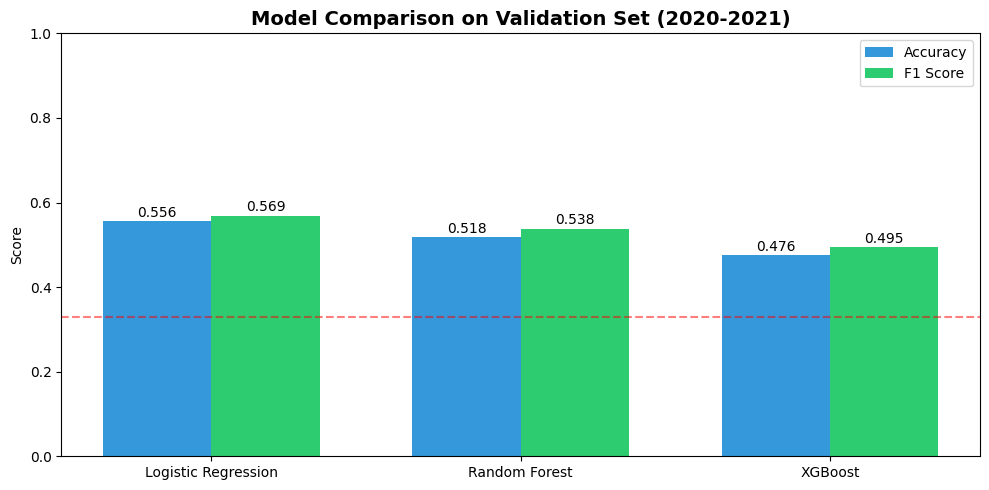


✅ Figure saved to ../reports/model_comparison.png


In [15]:
# ============================================
# VISUALIZE COMPARISON
# ============================================

fig, ax = plt.subplots(figsize=(10, 5))

models = [r[0] for r in results]
accuracies = [r[1] for r in results]
f1_scores = [r[2] for r in results]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#2ecc71')

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Comparison on Validation Set (2020-2021)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

# Add horizontal line at 0.33 (random guessing for 3 classes)
ax.axhline(y=0.33, color='red', linestyle='--', alpha=0.5, label='Random Baseline')

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/model_comparison.png")

---
## 8. Feature Importance

In [16]:
# ============================================
# RANDOM FOREST FEATURE IMPORTANCE
# ============================================

print("📊 RANDOM FOREST FEATURE IMPORTANCE:")
print("="*60)

# Get feature importances
importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importances.to_string(index=False))

📊 RANDOM FOREST FEATURE IMPORTANCE:
               Feature  Importance
   Efficiency_Mean_2yr    0.227341
      Efficiency_Ratio    0.115996
   Reports_Exactly_One    0.082224
    Expense_Growth_1yr    0.070197
   Revenue_Per_Athlete    0.063377
    Revenue_Growth_1yr    0.062503
      Expense_CAGR_2yr    0.057565
      Revenue_CAGR_2yr    0.056806
        Total_Athletes    0.054487
   Grand Total Revenue    0.054011
  Grand Total Expenses    0.051102
Expense_Volatility_2yr    0.048814
Revenue_Volatility_2yr    0.048282
      Division_Encoded    0.007295


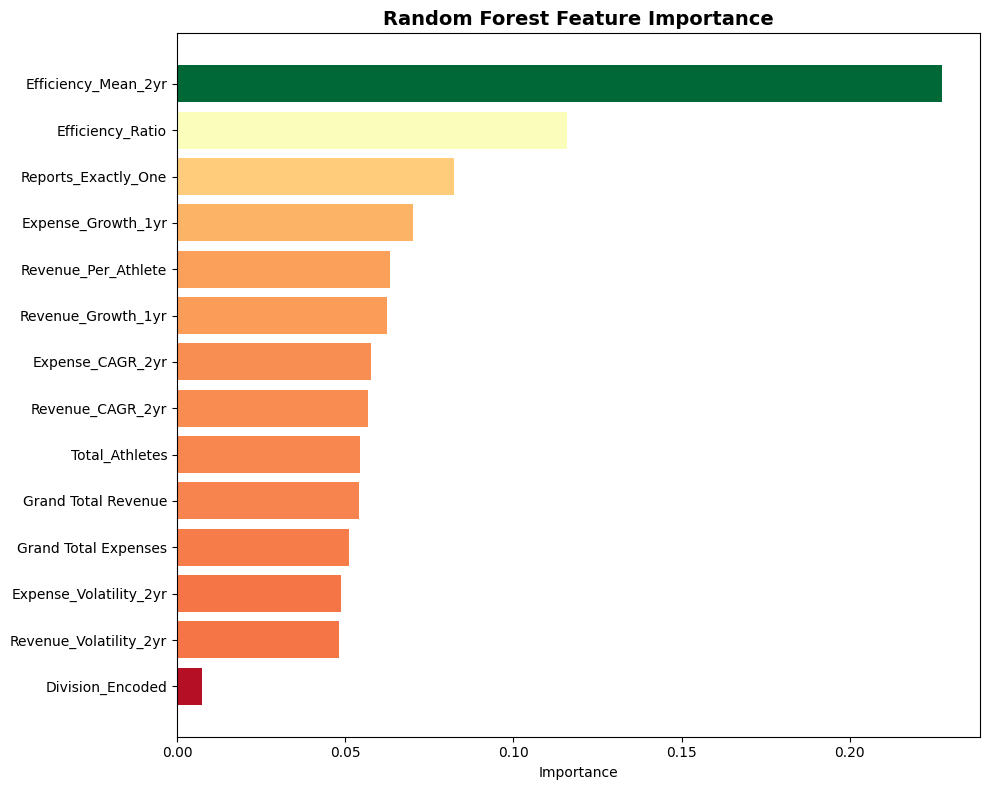


✅ Figure saved to ../reports/feature_importance.png


In [17]:
# ============================================
# VISUALIZE FEATURE IMPORTANCE
# ============================================

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.RdYlGn(importances['Importance'] / importances['Importance'].max())

bars = ax.barh(importances['Feature'], importances['Importance'], color=colors)

ax.set_xlabel('Importance')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/feature_importance.png")

---
## 9. Save Models

In [18]:
# ============================================
# CREATE MODELS DIRECTORY
# ============================================

os.makedirs('../models', exist_ok=True)

print("✅ Models directory created")

✅ Models directory created


In [19]:
# ============================================
# SAVE MODELS AND SCALER
# ============================================

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Saved scaler to ../models/scaler.pkl")

# Save feature columns
joblib.dump(feature_columns, '../models/feature_columns.pkl')
print("✅ Saved feature columns to ../models/feature_columns.pkl")

# Save train medians (for missing value imputation)
joblib.dump(train_medians, '../models/train_medians.pkl')
print("✅ Saved training medians to ../models/train_medians.pkl")

# Save Logistic Regression
joblib.dump(lr_model, '../models/logistic_regression.pkl')
print("✅ Saved Logistic Regression to ../models/logistic_regression.pkl")

# Save Random Forest
joblib.dump(rf_model, '../models/random_forest.pkl')
print("✅ Saved Random Forest to ../models/random_forest.pkl")

# Save XGBoost
if HAS_XGBOOST and xgb_model is not None:
    joblib.dump(xgb_model, '../models/xgboost.pkl')
    print("✅ Saved XGBoost to ../models/xgboost.pkl")

✅ Saved scaler to ../models/scaler.pkl
✅ Saved feature columns to ../models/feature_columns.pkl
✅ Saved training medians to ../models/train_medians.pkl
✅ Saved Logistic Regression to ../models/logistic_regression.pkl
✅ Saved Random Forest to ../models/random_forest.pkl
✅ Saved XGBoost to ../models/xgboost.pkl


---
## 10. Final Summary

In [20]:
# ============================================
# TRAINING SUMMARY
# ============================================

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                          MODEL TRAINING COMPLETE                             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING DATA:                                                              ║
║  ───────────────                                                             ║
║  • Years: 2017-2019                                                          ║
║  • Original samples: {len(y_train):,}                                                 ║
║  • After SMOTE: {len(y_train_resampled):,}                                                    ║
║  • Features: {len(feature_columns)}                                                         ║
║                                                                              ║
║  VALIDATION RESULTS (2020-2021):                                             ║
║  ────────────────────────────────                                            ║
║  • Logistic Regression:  Acc={lr_val_acc:.4f}  F1={lr_val_f1:.4f}                       ║
║  • Random Forest:        Acc={rf_val_acc:.4f}  F1={rf_val_f1:.4f}                       ║
║  • XGBoost:              Acc={xgb_val_acc if xgb_val_acc else 'N/A':}  F1={xgb_val_f1 if xgb_val_f1 else 'N/A':}                       ║
║                                                                              ║
║  BEST MODEL: {best_model_name}                                           ║
║                                                                              ║
║  SAVED ARTIFACTS:                                                            ║
║  ─────────────────                                                           ║
║  • ../models/scaler.pkl                                                      ║
║  • ../models/feature_columns.pkl                                             ║
║  • ../models/train_medians.pkl                                               ║
║  • ../models/logistic_regression.pkl                                         ║
║  • ../models/random_forest.pkl                                               ║
║  • ../models/xgboost.pkl                                                     ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

NEXT STEP: Proceed to 07_Model_Evaluation.ipynb
→ Evaluate on 2022 holdout test set for unbiased metrics
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════════╗
║                          MODEL TRAINING COMPLETE                             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING DATA:                                                              ║
║  ───────────────                                                             ║
║  • Years: 2017-2019                                                          ║
║  • Original samples: 5,166                                                 ║
║  • After SMOTE: 8,361                                                    ║
║  • Features: 14                                                         ║
║                                                                              ║
║  VALIDATION RESULTS (2020-2021):                                             ║
║  ────────────────────────────────   

---
## ✅ Checkpoint Complete

We've trained:
1. **Logistic Regression** - Fast, interpretable baseline
2. **Random Forest** - Ensemble with feature importance
3. **XGBoost** - Gradient boosting for complex patterns

**Class imbalance handled** with SMOTE oversampling.

**Important:** Validation results are NOT final metrics!
- Validation was used for tuning
- True performance will be on 2022 holdout

**Next Notebook:** `07_Model_Evaluation.ipynb`  
We'll evaluate all models on the 2022 holdout test set for unbiased performance metrics.